# Decoy State QKD Protocol Simulator

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import math
from ThOPqkdsim.simDecoyState import *

<div style="text-align: center;">
    <img src="Figures/Decoy_State/decoystatefig.png" width="800">
</div>

## <a name="introduction"></a>1. Introduction: Quantum Key Distribution (QKD)

**Quantum Key Distribution (QKD)** is a secure communication method which enables two parties (typically called Alice and Bob) to generate a shared, secret random key, which can be used for encrypting and decrypting messages. The security of QKD is based on the fundamental laws of quantum mechanics.


## <a name="decoy-state-background"></a>2. Decoy State QKD: Principles & Background

- **BB84 Protocol**: The first QKD protocol, which uses quantum states to encode bits.
- **Decoy State Method**: Enhances security and key rate by sending signal and decoy pulses of different intensities, thwarting photon-number-splitting (PNS) attacks.

Key concepts:
- **Signal state (`mu`)**: Mean photon number for the main signal pulse.
- **Decoy states (`nu1`, `nu2`)**: Lower-intensity pulses used to estimate channel parameters and detect eavesdropping.

---

<div style="text-align: center;">
    <img src="Figures/Decoy_State/QKD_sim-Decoy State qkd steps.png" width="800">
</div>

## <a name="decoystateqkd-class"></a>3. Simulator: The `DecoyStateQKD` Class

We now provide a class-based simulator for decoy-state QKD, with detailed explanations for each section.

### <a name="init-params"></a>Class Initialization & Parameters

- `wavelength`: The wavelength of the photons (nm), typically 1550 nm for minimal fiber loss.
- `alpha`: Fiber attenuation coefficient (dB/km), determines how much light is lost per km.
- `e_detector`: Probability that a detected photon is erroneous (e.g., due to misalignment or dark counts).
- `Y0`: Background count rate (probability of a click when no photon sent).
- `eta_bob`: Overall efficiency at Bob's side (product of Bob's optics and detector efficiency).
- `mu`: Signal state mean photon number (the average photons per pulse in signal).
- `nu1`, `nu2`: Decoy state mean photon numbers (typically, `nu2` is vacuum, i.e., 0).
- `f`: Error correction efficiency (relative to Shannon limit, >1).
- `q`: Protocol efficiency (1/2 for BB84, due to basis sifting).
- `rep_rate`: Pulse repetition rate (Hz).

#### Channel Parameters
- `channel_mode`: Type of quantum channel - "fiber" for optical fiber or "fso" for free space optical.

#### FSO-Specific Parameters
- `transmitter_diameter`: Diameter of transmitter aperture in meters.
- `receiver_diameter`: Diameter of receiver aperture in meters.
- `beam_divergence`: Beam divergence angle in radians (typically in milliradians).
- `pointing_error`: Pointing error in radians.
- `transmitter_efficiency`: Efficiency of transmitter optics.
- `receiver_efficiency`: Efficiency of receiver optics.

#### Optical Misalignment Parameters
- `misalignment_base`: Base misalignment error (1.5% by default).
- `misalignment_factor`: Increase in misalignment per km (0.0002 by default).

---

In [ ]:
class DecoystateqKDBbb84:
    def __init__(self, 
                 wavelength=1550,  # nm
                 alpha=0.21,       # dB/km (fiber loss coefficient)
                 e_detector=0.033, # detector error probability (3.3%)
                 Y0=1.7e-6,        # background rate
                 eta_bob=0.045,    # Bob's side efficiency (internal transmittance * detector efficiency)
                 mu=0.5,           # signal state intensity
                 nu1=0.1,          # decoy state 1 intensity
                 nu2=0.0,          # decoy state 2 intensity (vacuum)
                 f=1.22,           # error correction efficiency
                 q=0.5,            # protocol efficiency factor (1/2 for BB84)
                 rep_rate=2e6,     # repetition rate in Hz (2 MHz as default from Table 1)
                 channel_mode="fiber", # channel mode: "fiber" or "fso"
                 # FSO specific parameters
                 transmitter_diameter=0.1,    # Diameter of transmitter aperture in meters
                 receiver_diameter=0.3,       # Diameter of receiver aperture in meters
                 beam_divergence=0.001,       # Beam divergence angle in radians (1 mrad)
                 pointing_error=1e-6,         # Pointing error in radians
                 transmitter_efficiency=0.9,  # Efficiency of transmitter optics
                 receiver_efficiency=0.9      # Efficiency of receiver optics
                ):
        # QKD protocol parameters
        self.wavelength_nm = wavelength
        self.wavelength = wavelength * 1e-9  # Convert to meters for FSO calculations
        self.alpha = alpha
        self.e_detector = e_detector
        self.Y0 = Y0
        self.eta_bob = eta_bob
        self.mu = mu
        self.nu1 = nu1
        self.nu2 = nu2
        self.f = f
        self.q = q
        self.rep_rate = rep_rate
        self.e0 = 0.5  # error rate of background (random)
        
        # Channel parameters
        self.channel_mode = channel_mode
        self.distance = 0  # initialize with zero distance
        
        # FSO specific parameters
        self.transmitter_diameter = transmitter_diameter
        self.receiver_diameter = receiver_diameter
        self.beam_divergence = beam_divergence
        self.pointing_error = pointing_error
        self.transmitter_efficiency = transmitter_efficiency
        self.receiver_efficiency = receiver_efficiency
        
        # Optical misalignment parameters
        self.misalignment_base = 0.015     # 1.5% base misalignment error
        self.misalignment_factor = 0.0002  # Increase per km

The simulation supports two types of quantum channels: optical fiber and free-space optical (FSO) channels. The transmittance of these channels is calculated differently to reflect their distinct physical properties.

### Channel Mode Selection

The system allows switching between fiber and FSO channels:

```python
qkd.set_channel_mode("fiber")  # or "fso"
```

### Fiber Channel Transmittance

For optical fiber, transmittance follows an exponential decay model based on distance:

$$t_{AB}^{fiber} = 10^{-\frac{\alpha L}{10}}$$

Where:
- $\alpha$ is the fiber attenuation coefficient (dB/km)
- $L$ is the distance (km)

### Free Space Optical (FSO) Channel Transmittance

For FSO channels, transmittance depends on multiple factors:

$$t_{AB}^{FSO} = G_{geo} \cdot \eta_{tx} \cdot \eta_{rx} \cdot F_{turb} \cdot F_{pointing}$$

Where:
- $G_{geo}$ is the geometrical loss factor
- $\eta_{tx}$ is the transmitter optical efficiency
- $\eta_{rx}$ is the receiver optical efficiency
- $F_{turb}$ is the turbulence-induced loss factor
- $F_{pointing}$ is the pointing error loss factor

#### Geometrical Loss Factor

The geometrical loss factor accounts for beam spreading:

$$G_{geo} = (\frac{D_{rx}}{D_{beam}})^2)$$

Where:
- $D_{rx}$ is the receiver aperture diameter
- $D_{beam} = D_{tx} + L \cdot \theta_{div}$ is the beam diameter at the receiver
- $D_{tx}$ is the transmitter aperture diameter
- $\theta_{div}$ is the beam divergence angle

#### Turbulence-Induced Loss

Atmospheric turbulence causes scintillation that reduces transmittance:

$$F_{turb} = e^{-0.05L}$$

#### Pointing Error Loss

Pointing errors cause additional loss due to beam wandering:

$$F_{pointing} = \exp\left(-\frac{2\sigma_p^2}{w_L^2}\right)$$

Where:
- $\sigma_p^2 = (\theta_{err} \cdot L)^2$ is the pointing error variance
- $\theta_{err}$ is the pointing error angle
- $w_L^2 = (\theta_{div} \cdot L / 2)^2$ is the beam spot size at distance $L$

### Total Transmittance

Regardless of the channel type, the total transmittance includes Bob's detection efficiency:

$$\eta_{total} = t_{AB} \cdot \eta_{bob}$$

Where:
- $t_{AB}$ is the channel transmittance (either fiber or FSO)
- $\eta_{bob}$ is Bob's overall detection efficiency

### FSO Parameter Configuration

FSO parameters can be adjusted using:

```python
qkd.set_fso_parameters(
    transmitter_diameter=0.1,    # m
    receiver_diameter=0.3,       # m
    beam_divergence=0.001,       # rad
    pointing_error=1e-6,         # rad
    transmitter_efficiency=0.9,
    receiver_efficiency=0.9
)
```

These parameters significantly impact the maximum achievable distance and secure key rate in free-space QKD implementations.

In [ ]:
def calculate_channel_transmittance(self, distance):
        """Calculate channel transmittance based on distance and loss coefficient"""
        t_AB = 10 ** (-(self.alpha * distance) / 10)
        return t_AB
    
def calculate_total_transmittance(self, distance):
    """Calculate total transmittance including Bob's efficiency"""
    t_AB = self.calculate_channel_transmittance(distance)
    eta = t_AB * self.eta_bob
    return eta

### <a name="yields-errors"></a>Photon State Yields and Errors

**Yield (`Y_i`)**: Probability that an i-photon pulse causes a detection.

**Error rate (`e_i`)**: Probability that an i-photon pulse is detected incorrectly.
- `yield_i_photon`: Combines background and signal contributions.
- `error_i_photon`: Weighted sum of error contributions from dark counts and detector errors.

#### Yields and Errors

- **Yield**: Probability that a pulse with $i$ photons produces a click at Bob.

$
Y_i = Y_0 + \eta_i - Y_0 \eta_i \approx Y_0 + \eta_i
$
where $\eta_i = 1 - (1-\eta)^i$

- **Error rate for i-photon state**:
$
e_i = \frac{e_0 Y_0 + e_{detector} \eta_i}{Y_i}
$


---

In [ ]:
def set_channel_mode(self, mode):
        """
        Set the channel mode to either fiber or FSO

        Args:
                mode (str): Either "fiber" or "fso"
        """
        if mode not in ["fiber", "fso"]:
                raise ValueError(f"Unsupported channel mode: {mode}. Use 'fiber' or 'fso'.")

        self.channel_mode = mode

def set_fso_parameters(self, transmitter_diameter=None, receiver_diameter=None, 
                        beam_divergence=None, wavelength=None, pointing_error=None,
                        transmitter_efficiency=None, receiver_efficiency=None):
        """
        Update FSO-specific parameters. Only updates the parameters that are provided.

        Args:
                transmitter_diameter (float, optional): Diameter of transmitter aperture in meters
                receiver_diameter (float, optional): Diameter of receiver aperture in meters
                beam_divergence (float, optional): Beam divergence angle in radians
                wavelength (float, optional): Wavelength in nm
                pointing_error (float, optional): Pointing error in radians
                transmitter_efficiency (float, optional): Efficiency of transmitter optics
                receiver_efficiency (float, optional): Efficiency of receiver optics
        """
        if transmitter_diameter is not None:
                self.transmitter_diameter = transmitter_diameter
        if receiver_diameter is not None:
                self.receiver_diameter = receiver_diameter
        if beam_divergence is not None:
                self.beam_divergence = beam_divergence
        if wavelength is not None:
                self.wavelength_nm = wavelength
                self.wavelength = wavelength * 1e-9  # Convert to meters
        if pointing_error is not None:
                self.pointing_error = pointing_error
        if transmitter_efficiency is not None:
                self.transmitter_efficiency = transmitter_efficiency
        if receiver_efficiency is not None:
                self.receiver_efficiency = receiver_efficiency

def calculate_fiber_transmittance(self, distance):
        """Calculate channel transmittance for fiber based on distance and loss coefficient"""
        t_AB = 10 ** (-(self.alpha * distance) / 10)
        return t_AB

def calculate_fso_transmittance(self, distance):
        """Calculate channel transmittance for FSO channel"""
        # For zero distance, return direct efficiency without atmospheric effects
        if distance <= 1e-6:  # Effectively zero
                return self.transmitter_efficiency * self.receiver_efficiency

        # Calculate geometrical loss factor
        beam_diameter_at_receiver = self.transmitter_diameter + (distance * 1000 * self.beam_divergence)
        geo_factor = min(1.0, (self.receiver_diameter / beam_diameter_at_receiver)**2)

        # Calculate simplified turbulence-induced scintillation loss
        turb_factor = np.exp(-0.05 * distance)  # Simplified exponential decay with distance

        # Calculate simplified beam wandering effect
        pointing_variance = (self.pointing_error * distance * 1000)**2
        beam_spot_size = (self.beam_divergence * distance * 1000 / 2)**2
        bw_factor = np.exp(-2 * pointing_variance / beam_spot_size)

        # Calculate overall transmission efficiency
        total_efficiency = (geo_factor * self.transmitter_efficiency * 
                                self.receiver_efficiency * turb_factor * bw_factor)

        return min(1.0, max(0.0, total_efficiency))  # Ensure efficiency is between 0 and 1

def calculate_channel_transmittance(self, distance):
        """Calculate channel transmittance based on channel mode"""
        if self.channel_mode == "fiber":
                return self.calculate_fiber_transmittance(distance)
        elif self.channel_mode == "fso":
                return self.calculate_fso_transmittance(distance)
        else:
                raise ValueError(f"Unsupported channel mode: {self.channel_mode}")

def calculate_total_transmittance(self, distance):
        """Calculate total transmittance including Bob's efficiency"""
        t_AB = self.calculate_channel_transmittance(distance)
        eta = t_AB * self.eta_bob
        return eta


### <a name="gain-qber"></a>Gain and QBER Calculations

- **Gain (`Q`)**: Probability that Bob registers a click per pulse.
- **QBER**: Quantum Bit Error Rate (fraction of erroneous bits).

#### Gain

- **Gain for i-photon state**:
$
Q_i = Y_i \frac{\mu^i}{i!} e^{-\mu}
$

- **Overall gain**:
$
Q_\mu = Y_0 + 1 - e^{-\eta \mu}
$

- **Overall error**:
$
E_\mu Q_\mu = e_0 Y_0 + e_{detector}(1 - e^{-\eta \mu})
$
$
E_\mu = \frac{E_\mu Q_\mu}{Q_\mu}
$


### Detailed QBER Calculation

The `detailed_QBER` function implements a sophisticated model for calculating the Quantum Bit Error Rate (QBER) based on photon number decomposition. This approach provides a more accurate error estimation by accounting for the different behaviors of vacuum states, single-photon states, and multi-photon states.

#### Mathematical Model

The QBER calculation follows these steps:

1. **Photon Number State Probabilities**

   For a coherent state with mean photon number $\mu$, the probabilities of different photon number states are:
   
   $$P_{vacuum} = e^{-\mu}$$
   $$P_{single} = \mu \cdot e^{-\mu}$$
   $$P_{multi} = 1 - P_{vacuum} - P_{single}$$

2. **Detection Probabilities (Yields)**

   For each photon number state, we calculate the probability of detection:
   
   $$Y_{vacuum} = Y_0$$
   $$Y_{single} = \eta + Y_0 - \eta \cdot Y_0$$
   $$Y_{multi} = 1 - (1-\eta)^2 + Y_0 - Y_0 \cdot [1-(1-\eta)^2]$$
   
   where:
   - $Y_0$ is the background detection rate
   - $\eta$ is the channel transmittance

3. **Gain Calculation**

   The gain represents the contribution of each photon number component to the overall detection rate:
   
   $$Q_{vacuum} = P_{vacuum} \cdot Y_{vacuum}$$
   $$Q_{single} = P_{single} \cdot Y_{single}$$
   $$Q_{multi} = P_{multi} \cdot Y_{multi}$$

4. **Error Probabilities**

   Each component has a different error probability:
   
   $$E_{vacuum} = 0.5$$ 
   $$E_{single} = e_{detector}$$ 
   $$E_{multi} = e_{detector} \cdot (1 + 0.1\mu)$$ 

5. **Final QBER**

   The total QBER is calculated as the ratio of erroneous detections to total detections:
   
   $$QBER = \frac{Q_{vacuum} \cdot E_{vacuum} + Q_{single} \cdot E_{single} + Q_{multi} \cdot E_{multi}}{Q_{vacuum} + Q_{single} + Q_{multi}}$$

This model accounts for:
- Dark count contributions (vacuum state)
- Detector errors in single-photon states
- Enhanced errors in multi-photon states
- Channel transmittance effects on detection probabilities

---

In [1]:
def gain_i_photon(self, i, mu, eta):
    """Calculate gain for i-photon state"""

    Y_i = self.yield_i_photon(i, eta)
    Q_i = Y_i * (mu ** i / np.math.factorial(i)) * np.exp(-mu)
    return Q_i

def overall_gain(self, mu, eta):
    """Calculate overall gain"""
    Q_mu = self.Y0 + (1 - np.exp(-eta * mu))
    return Q_mu

def overall_error(self, mu, eta):
        """Calculate overall error"""
        Q_mu = self.overall_gain(mu, eta)
        E_mu_Q_mu = self.e0 * self.Y0 + self.e_detector * (1 - np.exp(-eta * mu))
        E_mu = E_mu_Q_mu / Q_mu
        return E_mu

def detailed_QBER(self, mu, eta, distance=0):
        """
        Calculate detailed QBER based on photon number decomposition,
        with improved modeling for FSO channel to match physical observations.
        
        Args:
            mu: Signal state intensity
            eta: Channel transmittance
            distance: Distance in km (used for misalignment error calculation)
            
        Returns:
            QBER value (as a ratio, not percentage)
        """
        # Calculate probabilities of different photon number states
        p_vacuum = np.exp(-mu)  # Probability of vacuum state
        p_single = mu * np.exp(-mu)  # Probability of single-photon state
        p_multi = 1 - p_vacuum - p_single  # Probability of multi-photon states
        
        # Calculate detection probabilities
        Y_vacuum = self.Y0
        Y_single = eta + self.Y0 - eta * self.Y0
        Y_multi = 1 - (1-eta)**2 + self.Y0 - self.Y0 * (1-(1-eta)**2)
        
        # Calculate gains for each component
        Q_vacuum = p_vacuum * Y_vacuum
        Q_single = p_single * Y_single
        Q_multi = p_multi * Y_multi
        
        # Calculate error rates for each component
        E_vacuum = 0.5  # Random errors for vacuum (dark counts)
        E_single = self.e_detector
        E_multi = self.e_detector * (1 + 0.1 * mu)

        # Calculate overall QBER using weighted average
        total_gain = Q_vacuum + Q_single + Q_multi
        total_error = (Q_vacuum * E_vacuum + Q_single * E_single + Q_multi * E_multi)
        
        qber = total_error / total_gain if total_gain > 0 else 0
        return qber

### <a name="decoy-estimation"></a>Decoy Parameter Estimation

Estimates for the single-photon yield (`Y1_L`), background (`Y0_L`), single-photon error (`e1_U`), and gain (`Q1_L`) using **decoy state analysis**.

### Decoy State Estimation (Lower/Upper Bounds)

- **Lower bound for $Y_0$** (Eq. 18):

$
Y_0^L = \frac{\nu_1 Q_{\nu_2} e^{\nu_2} - \nu_2 Q_{\nu_1} e^{\nu_1}}{\nu_1 - \nu_2}
$

- **Lower bound for $Y_1\)** (Eq. 21):

$
Y_1^L = \frac{\mu}{\mu \nu_1 - \mu \nu_2 - \nu_1^2 + \nu_2^2} \left[ Q_{\nu_1} e^{\nu_1} - Q_{\nu_2} e^{\nu_2} - \frac{\nu_1^2 - \nu_2^2}{\mu^2} (Q_\mu e^{\mu} - Y_0^L) \right]
$

- **Lower bound for single-photon gain:**
$
Q_1^L = Y_1^L \mu e^{-\mu}
$

- **Upper bound for single-photon error:**
$
e_1^U = \frac{E_{\nu_1} Q_{\nu_1} e^{\nu_1} - E_{\nu_2} Q_{\nu_2} e^{\nu_2}}
{(\nu_1 - \nu_2) Y_1^L}
$


---

In [16]:
def estimate_Y0_lower_bound(self, Q_nu1, Q_nu2):
    """Estimate lower bound of Y0 using Equation (18)"""
    Y0_L = max((self.nu1 * Q_nu2 * np.exp(self.nu2) - self.nu2 * Q_nu1 * np.exp(self.nu1)) / 
                (self.nu1 - self.nu2), 0)
    return Y0_L

def estimate_Y1_lower_bound(self, Q_mu, Q_nu1, Q_nu2, Y0_L):
    """Estimate lower bound of Y1 using Equation (21)"""
    numerator = Q_nu1 * np.exp(self.nu1) - Q_nu2 * np.exp(self.nu2) - \
                ((self.nu1**2 - self.nu2**2) / self.mu**2) * (Q_mu * np.exp(self.mu) - Y0_L)
    denominator = self.mu * self.nu1 - self.mu * self.nu2 - self.nu1**2 + self.nu2**2
    
    # Handle division by zero
    if abs(denominator) < 1e-10:
        denominator = 1e-10 if denominator >= 0 else -1e-10
        
    Y1_L = (self.mu / denominator) * numerator
    return Y1_L

def estimate_Q1_lower_bound(self, Q_mu, Q_nu1, Q_nu2, Y0_L):
    """Estimate lower bound of Q1 using Equation (22)"""
    Y1_L = self.estimate_Y1_lower_bound(Q_mu, Q_nu1, Q_nu2, Y0_L)
    Q1_L = Y1_L * self.mu * np.exp(-self.mu)
    return Q1_L

def estimate_e1_upper_bound(self, Q_nu1, Q_nu2, E_nu1, E_nu2, Y1_L):
    """Estimate upper bound of e1 using Equation (25)"""
    # Check for division by zero in individual terms
    nu_diff = self.nu1 - self.nu2
    if abs(nu_diff) < 1e-10:
        nu_diff = 1e-10 if nu_diff >= 0 else -1e-10
        
    # Ensure Y1_L is not zero
    if abs(Y1_L) < 1e-10:
        Y1_L = 1e-10
        
    e1_U = (E_nu1 * Q_nu1 * np.exp(self.nu1) - E_nu2 * Q_nu2 * np.exp(self.nu2)) / \
        (nu_diff * Y1_L)
    return e1_U

### <a name="key-rate"></a>Key Rate Calculation

**Secure key rate** formula (per second), based on decoy-state analysis.

#### Secure Key Rate

- **Binary entropy:**
$
H_2(x) = -x\log_2 x - (1-x)\log_2(1-x)
$

- **Secure key rate per pulse:**
$
R = q \left[ -Q_\mu f H_2(E_\mu) + Q_1^L (1 - H_2(e_1^U)) \right]
$
- **Convert to bits/sec:**
$
R_{bps} = R \times \text{rep\_rate}
$

In [ ]:
def key_rate(self, distance):
    """Calculate secure key rate using Equation (26)"""
    eta = self.calculate_total_transmittance(distance)
    
    # Calculate the gains and QBERs for signal and decoy states
    Q_mu = self.overall_gain(self.mu, eta)
    Q_nu1 = self.overall_gain(self.nu1, eta)
    Q_nu2 = self.overall_gain(self.nu2, eta)
    
    E_mu = self.overall_error(self.mu, eta)
    E_nu1 = self.overall_error(self.nu1, eta)
    E_nu2 = self.overall_error(self.nu2, eta)

    # Estimate parameters using decoy state method
    Y0_L = self.estimate_Y0_lower_bound(Q_nu1, Q_nu2)
    Y1_L = self.estimate_Y1_lower_bound(Q_mu, Q_nu1, Q_nu2, Y0_L)
    Q1_L = self.estimate_Q1_lower_bound(Q_mu, Q_nu1, Q_nu2, Y0_L)
    e1_U = self.estimate_e1_upper_bound(Q_nu1, Q_nu2, E_nu1, E_nu2, Y1_L)
    
    # Shannon entropy
    def H2(x):
        """Calculate binary Shannon entropy with safety checks for numerical stability"""
        # Handle values outside [0,1] range by clamping
        if x <= 0 or x >= 1:
            return 0
        
        # Additional protection for values extremely close to 0 or 1
        epsilon = 1e-15  # Small value to prevent log(0)
        x = max(min(x, 1-epsilon), epsilon)

        return -x * np.log2(x) - (1-x) * np.log2(1-x)
    
    # Calculate secure key rate using Equation (1)
    R_per_pulse = self.q * (-Q_mu * self.f * H2(E_mu) + Q1_L * (1 - H2(e1_U)))
    R_per_second = R_per_pulse * self.rep_rate
    
    return max(0, R_per_second), E_mu, Q_mu, Y1_L, e1_U, Q1_L

## QBER calculation

<div style="text-align: center;">
    <img src="Figures/Decoy_State/QKD_sim-decoystateqkd-qber.png" width="800">
</div>

## SKR calculation

<div style="text-align: center;">
    <img src="Figures/Decoy_State/QKD_sim-decoystateqkd-skr (1).png" width="500">
</div>

<a id='section4'></a>
## 4. Simulator Demo: Exploring QKD Performance

Let's analyze and visualize how different system parameters affect secure key rate and QBER.

In [48]:
def run_decoy_state_qkd_simulation_fiber():
    """Main function to demonstrate the QKD simulator"""
    # Define simulation parameters
    params = {
        'wavelength': 1550,     # nm
        'alpha': 0.21,          # dB/km
        'e_detector': 0.033,    # detector error probability (3.3%)
        'Y0': 1.7e-6,           # background rate
        'eta_bob': 0.045,       # Bob's side efficiency
        'mu': 0.5,              # signal state intensity
        'nu1': 0.1,             # decoy state 1 intensity
        'nu2': 0.0,             # decoy state 2 intensity (vacuum)
        'f': 1.22,              # error correction efficiency
        'q': 0.5,               # protocol efficiency factor (1/2 for BB84)
        'rep_rate': 1e6,         # repetition rate in Hz 
        'channel_mode': 'fiber'  # Channel mode (fiber or fso)
    }
    
    # Create QKD simulator with specified parameters
    qkd = DecoyStateQKD(**params)
    
    # Example of calculating key rate at specific distance
    distance = 50  # km
    rate, qber, gain, Y1_L, e1_U, Q1_L = qkd.key_rate(distance)
    print(f"Key Rate at {distance} km: {rate:.2f} bits/s")
    print(f"QBER at {distance} km: {qber*100:.2f}%")
    
    # Generate plots

    plot_qber_vs_mu(qkd, distance=50, channel_mode='fiber')
    plot_qber_vs_distance(qkd, channel_mode='fiber')
    plot_key_rate_vs_distance(qkd, channel_mode='fiber')
    plot_key_rate_vs_mu(qkd, distance=50, channel_mode='fiber')
    plot_key_rate_vs_error(qkd, distance=50, channel_mode='fiber')

    # Example of parameter optimization
    print("\nFinding optimal signal state intensity...")
    mu_values, mu_key_rates, _ = analyze_mu_dependence(qkd, distance=50)
    optimal_idx = np.argmax(mu_key_rates)
    print(f"Optimal μ at 50 km: {mu_values[optimal_idx]:.2f}")
    print(f"Optimal key rate: {mu_key_rates[optimal_idx]:.2f} bits/s")

def run_decoy_state_qkd_simulation_fso():
    """Main function to demonstrate the QKD simulator"""
    # Define simulation parameters
    params = {
        'wavelength': 1550,     # nm
        'alpha': 0.21,          # dB/km
        'e_detector': 0.033,    # detector error probability (3.3%)
        'Y0': 1.7e-6,           # background rate
        'eta_bob': 0.045,       # Bob's side efficiency
        'mu': 0.5,              # signal state intensity
        'nu1': 0.1,             # decoy state 1 intensity
        'nu2': 0.0,             # decoy state 2 intensity (vacuum)
        'f': 1.22,              # error correction efficiency
        'q': 0.5,               # protocol efficiency factor (1/2 for BB84)
        'rep_rate': 1e6,         # repetition rate in Hz 
        'channel_mode': 'fso'  # Channel mode (fiber or fso)
    }
    
    # Create QKD simulator with specified parameters
    qkd = DecoyStateQKD(**params)
    
    # Example of calculating key rate at specific distance
    distance = 5  # km
    rate, qber, gain, Y1_L, e1_U, Q1_L = qkd.key_rate(distance)
    print(f"Key Rate at {distance} km: {rate:.2f} bits/s")
    print(f"QBER at {distance} km: {qber*100:.2f}%")
    
    # Generate plots
    
    plot_qber_vs_mu(qkd, distance=1.5, channel_mode='fso')
    plot_qber_vs_distance(qkd, channel_mode='fso')
    plot_key_rate_vs_distance(qkd, max_distance=20,channel_mode='fso')
    plot_key_rate_vs_mu(qkd, distance=1.5, channel_mode='fso')
    plot_key_rate_vs_error(qkd, distance=1.5, channel_mode='fso')

    # Example of parameter optimization
    print("\nFinding optimal signal state intensity...")
    mu_values, mu_key_rates, _ = analyze_mu_dependence(qkd, distance=5)
    optimal_idx = np.argmax(mu_key_rates)
    print(f"Optimal μ at 2 km: {mu_values[optimal_idx]:.2f}")
    print(f"Optimal key rate: {mu_key_rates[optimal_idx]:.2f} bits/s")


Key Rate at 50 km: 194.58 bits/s
QBER at 50 km: 3.34%


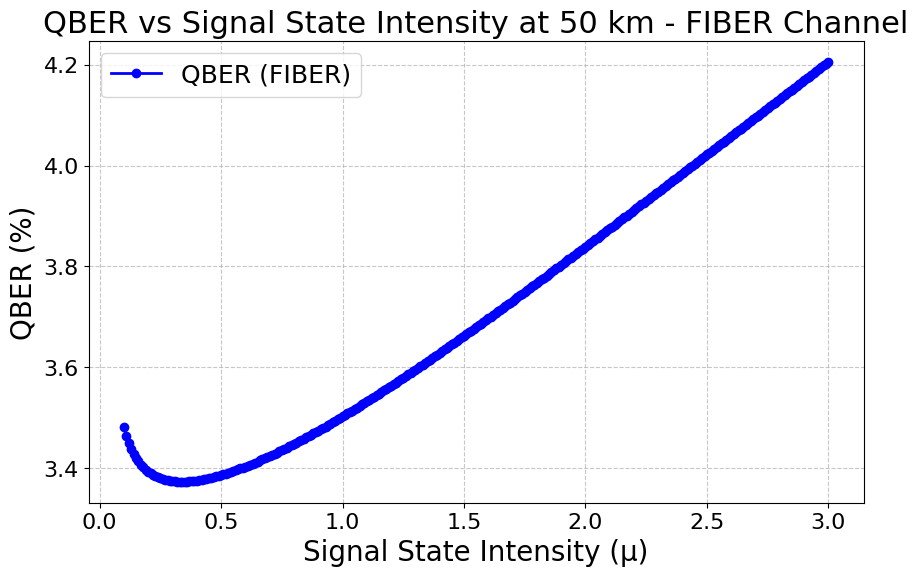

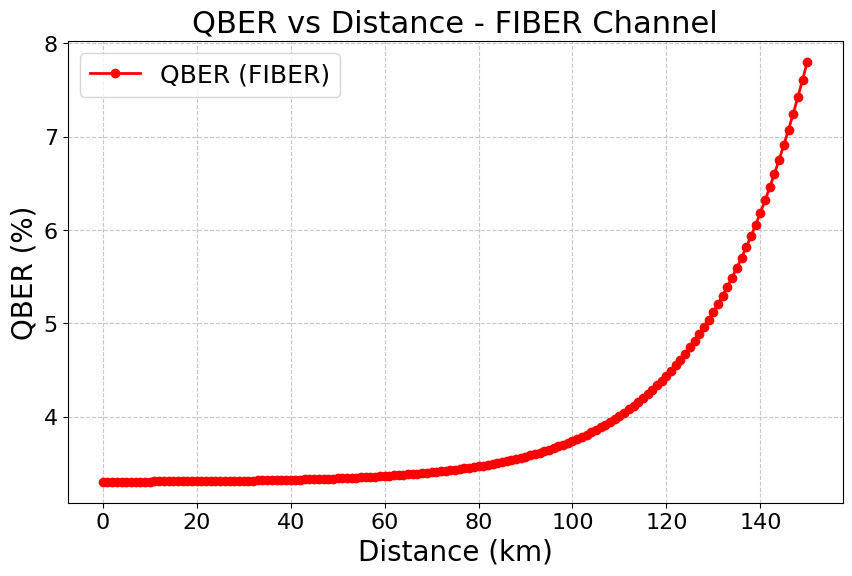

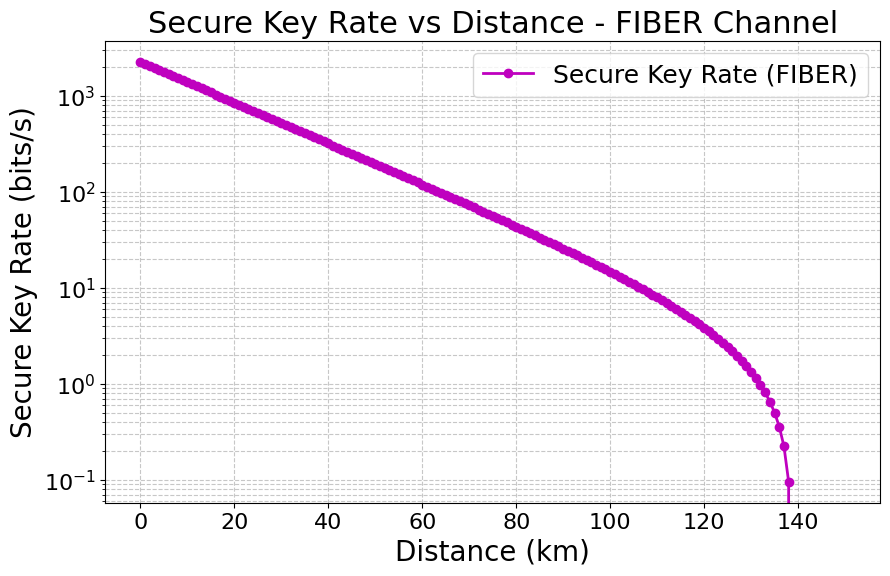

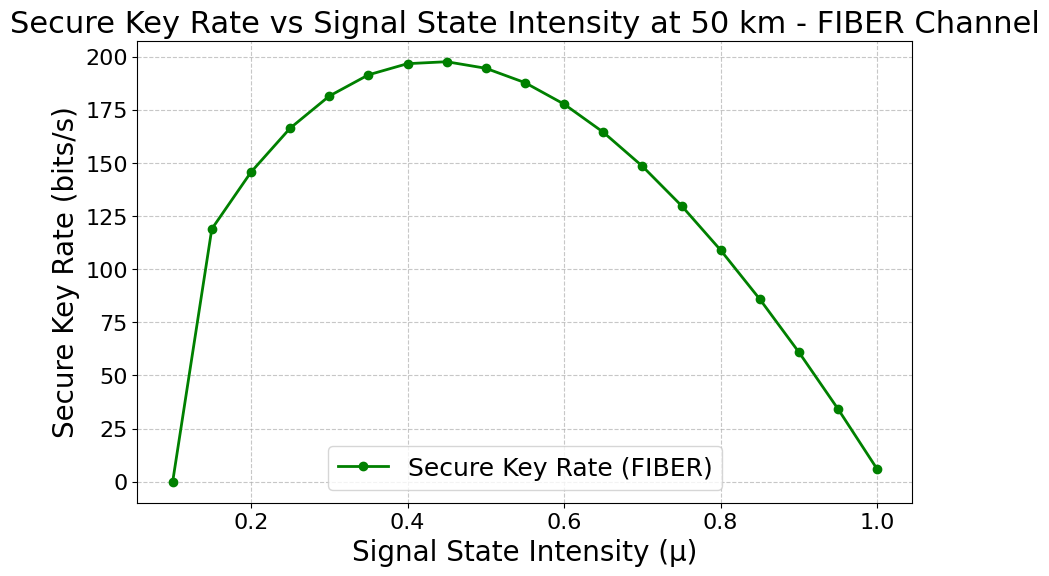

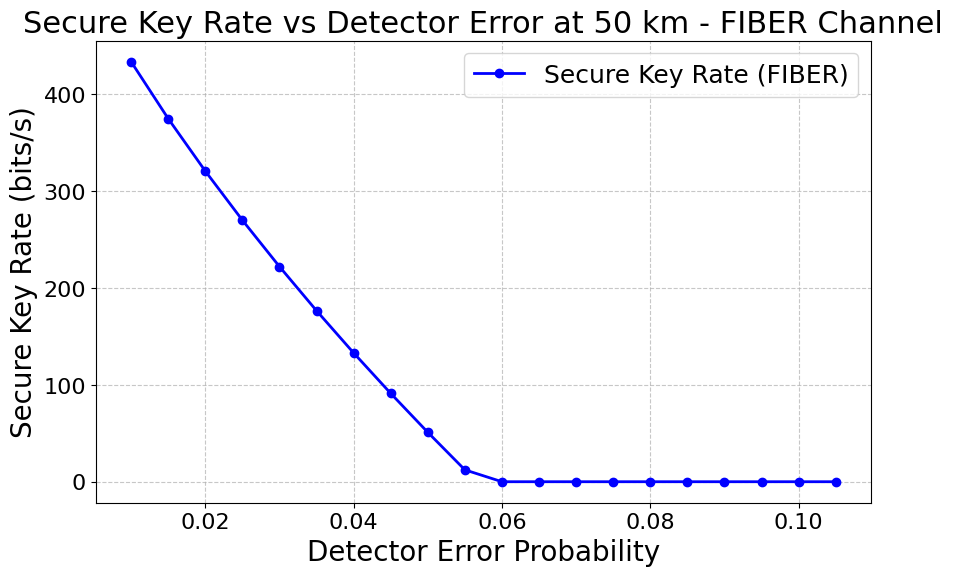


Finding optimal signal state intensity...
Optimal μ at 50 km: 0.45
Optimal key rate: 197.67 bits/s


In [49]:
run_decoy_state_qkd_simulation_fiber()

Key Rate at 5 km: 2.03 bits/s
QBER at 5 km: 4.86%


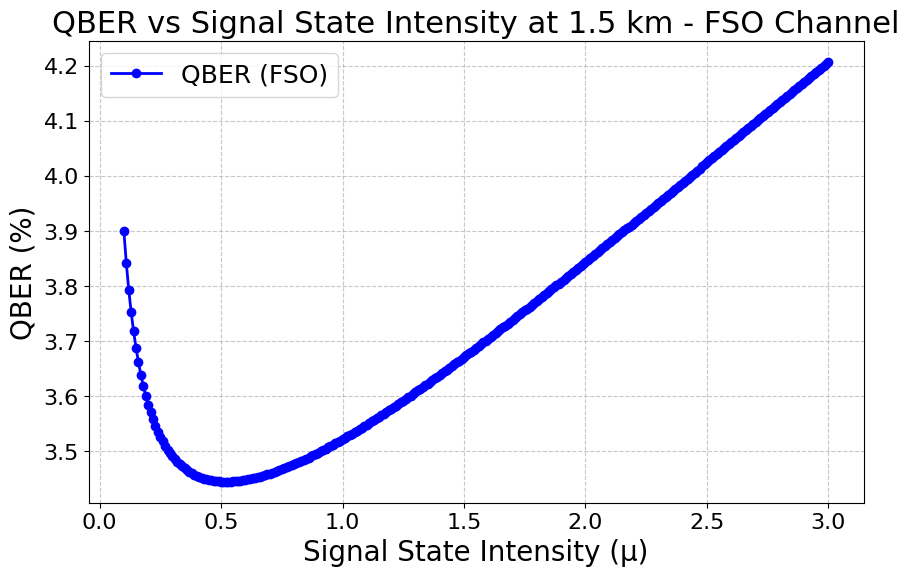

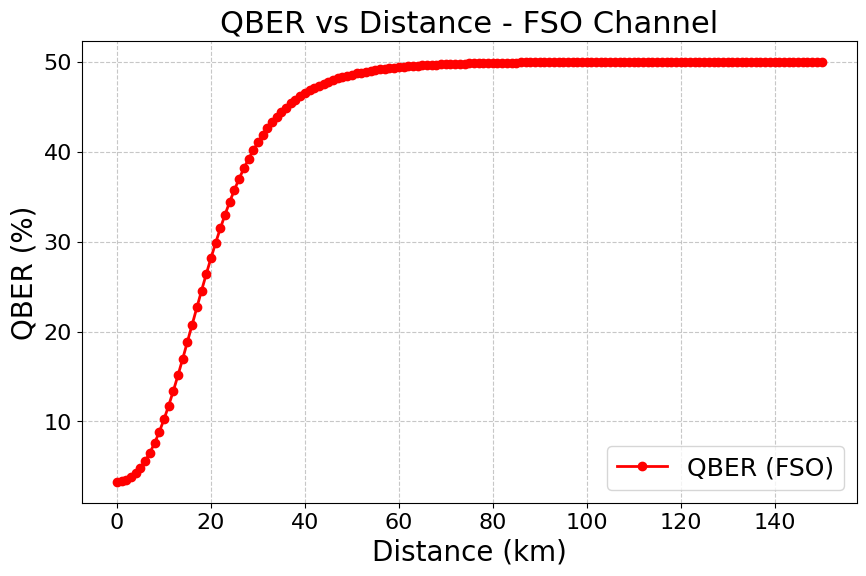

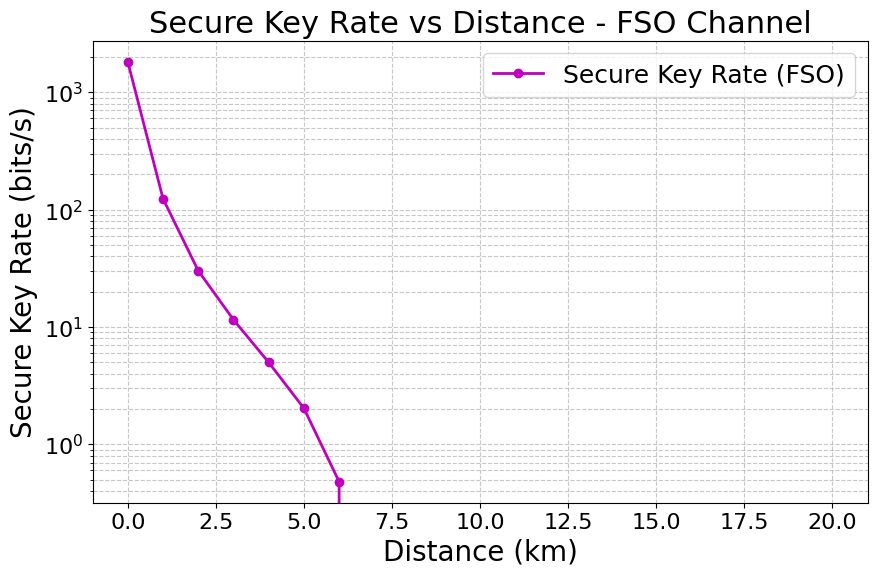

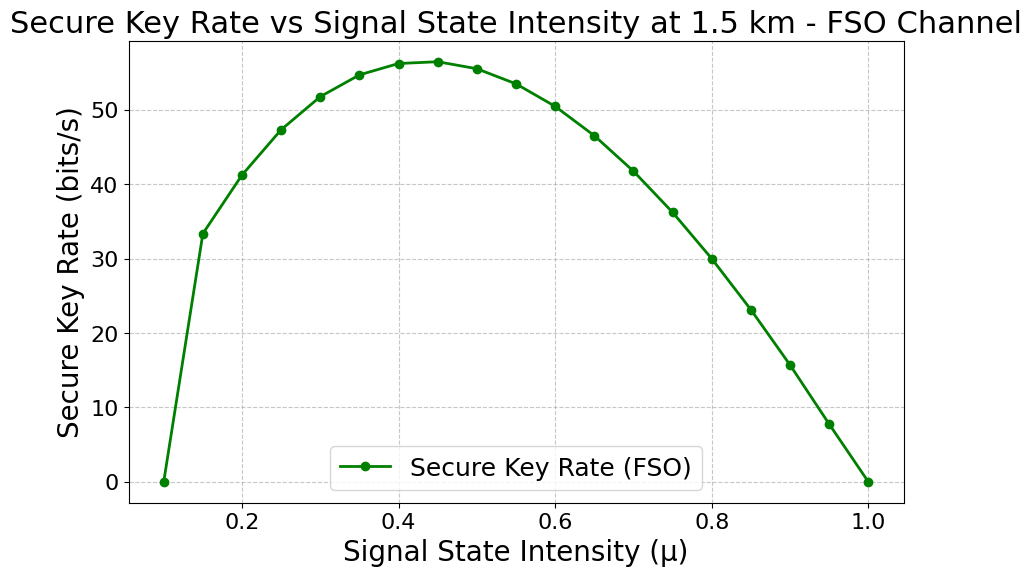

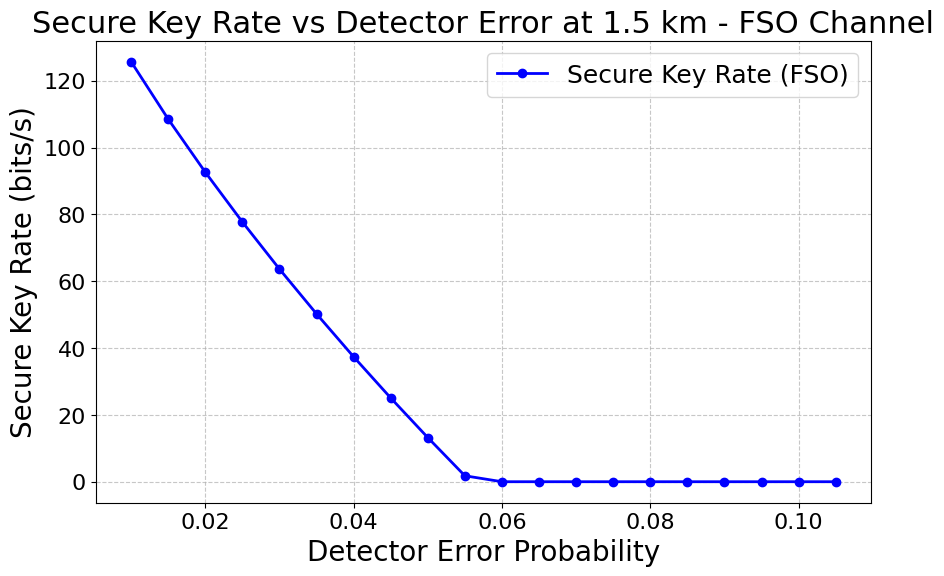


Finding optimal signal state intensity...
Optimal μ at 2 km: 0.45
Optimal key rate: 1784.49 bits/s


In [50]:
run_decoy_state_qkd_simulation_fso()

## 5. Conclusion and Future Work

### Conclusion

In this module, we developed and analyzed a comprehensive Decoy State BB84 Quantum Key Distribution (QKD) simulator. By methodically exploring the effects of fiber attenuation, detector imperfections, and protocol parameters

Key takeaways include:
- The secure key rate drops exponentially with channel distance, primarily due to fiber loss and increased relative impact of detector dark counts.
- An optimal signal intensity (\(\mu\)) exists that maximizes the key rate for a given distance, balancing between higher signal detection probability and increased vulnerability to multi-photon attacks.
- Detector error and dark count rates significantly impact both key rate and QBER, especially at long distances.
- The decoy-state method allows rigorous estimation of single-photon contributions, ensuring security against advanced eavesdropping strategies.

### Future Work

While this simulator provides a solid foundation for studying decoy-state BB84 QKD, several avenues for further exploration and enhancement remain:

1. **Finite-Key Effects:**  
   Incorporate finite-size statistical effects, rather than assuming an infinite number of signals, to more accurately reflect real experimental scenarios.

2. **More Realistic Error Models:**  
   Extend the error model to include misalignment errors, afterpulsing, and time-dependent effects.

3. **Additional Protocols:**  
   Expand the simulator to include other QKD protocols such as Measurement-Device-Independent (MDI) QKD or Continuous-Variable (CV) QKD.

4. **Optimization Tools:**  
   Implement automatic parameter optimization routines to find ideal settings (\(\mu\), \(\nu_1\), \(\nu_2\), etc.) for specific experimental setups or requirements.

5. **Security Analysis Enhancements:**  
   Integrate composable security proof frameworks and advanced statistical tools for even more rigorous analysis of security bounds.

6. **Visualization and Interactivity:**  
   Build interactive widgets (using, e.g., ipywidgets) for real-time parameter adjustment and immediate feedback in Jupyter notebooks.

7. **Experimental Data Integration:**  
   Allow users to input real experimental data to validate the theoretical model and analyze real-world system performance.

---